## Overview

In this tutorial, we will build a simple aritificial neural network (ANN), also known as multilayer perceptron (MLP) or feedforward neural network (FNN). The learning outcomes are:
1. Understand how the model is formulated mathematically;
2. Understand what is meant by training the network;
3. Experiment with more complex architectures.

## Data

We generate data from a Gaussian process with a specified covariance matrix. The details of data generation do not matter as in reality, you never know the actual data generation machanism.

**The key** here is that we want to predict $y \in R^5$ given the previous values $x\in R^{25}$.

In [1]:
# first let's generate data, you can ignore this part
import numpy as np
import sys
import os
sys.path.insert(1, '..')
os.chdir('..')

from data_formatters.iglu import *
from dataset import TSDataset
from conf import Conf

import torch
from torch.utils.data import TensorDataset

# load config file
cnf = Conf(conf_file_path='./conf/iglu.yaml', seed=15, exp_name="IGLU", log=False)
data_formatter = IGLUFormatter(cnf)

# set up torch datasets: train, val, test
train_dataset = TSDataset(cnf, data_formatter, data_formatter.train_data)
val_dataset = TSDataset(cnf, data_formatter, data_formatter.val_data)
test_dataset = TSDataset(cnf, data_formatter, data_formatter.test_data)

# train_idx, test_idx, val_idx = map(set, data_formatter.split_data())
# train, test, val = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

# for index, row in data_formatter.data.iterrows():
#     if index in train_idx:
#         train.append(row)
#     elif index in test_idx:
#         test.append(row)
#     else:
#         val.append(row)

# # These are empty for some reason
# print(train, test, val)
# x_columns = ["time"]
# y_columns = ["gl"]
# train_x, test_x, val_x, = map(lambda x: x[x_columns], [train, test, val])
# train_y, test_y, val_y, = map(lambda x: x[y_columns], [train, test, val])

# train_dataset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
# test_dataset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
# val_dataset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
# # set up torch dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_dataset.data

Dropped segments: 11
Extracted segments: 21
Getting valid sampling locations.
# available segments=5710
Extracting 5000 samples out of 5710
1000 of 5000 samples done...
2000 of 5000 samples done...
3000 of 5000 samples done...
4000 of 5000 samples done...
5000 of 5000 samples done...
Getting valid sampling locations.
# available segments=11
Extracting all available segments.
Getting valid sampling locations.
# available segments=776
Extracting all available segments.


,time,id,gl,segment,id_segment,year,month,day,hour,minute
0,2015-06-06 16:50:00,0,0.005425,0.0,Subject 1_0.0,2015,6,6,16,50
1,2015-06-06 16:55:00,0,-0.089361,0.0,Subject 1_0.0,2015,6,6,16,55
2,2015-06-06 17:00:00,0,-0.184146,0.0,Subject 1_0.0,2015,6,6,17,0
3,2015-06-06 17:05:00,0,-0.278932,0.0,Subject 1_0.0,2015,6,6,17,5
4,2015-06-06 17:10:00,0,-0.438883,0.0,Subject 1_0.0,2015,6,6,17,10
...,...,...,...,...,...,...,...,...,...,...
13867,2015-03-10 15:45:00,4,-0.563289,5.0,Subject 5_5.0,2015,3,10,15,45
13868,2015-03-10 15:50:00,4,-0.598834,5.0,Subject 5_5.0,2015,3,10,15,50
13869,2015-03-10 15:55:00,4,-0.616606,5.0,Subject 5_5.0,2015,3,10,15,55
13870,2015-03-10 16:00:00,4,-0.545517,5.0,Subject 5_5.0,2015,3,10,16,0


## Linear regression

Suppose we want to model our data as a linear transformation, that is we aim to find $W \in R^{25\times 5}$ so that to minimize the squared error between the prediction and the truth. In summary, we formulate the problem as:
$$
W^* = \argmin_{W} || Y -  XW ||^2
$$

This model is an extension of the model many of us have covered in the introductory statisics courses to a multivariate case. **Recall** that for one-dimensional case (i.e. when $y \in R$) and under some distributional assumptions, this optimization problem has a closed form solution that is guaranteed to be the best (BLUE). When we move to more dimensions and start relaxing the assumptions, we no longer have the closed-form solution. Hence, we need to resort to the apprximate methods. Below, we program the model and see its performance.

In [2]:
import torch
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear_collapse = torch.nn.Linear(6, 1)
        self.linear = torch.nn.Linear(192, 24)
        
    def forward(self, x):
        y_pred = self.linear(torch.squeeze(self.linear_collapse(x)))
        return y_pred

In [3]:
# train model
best_loss = 1e1000
model = LinearModel()
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for epoch in range(10):
    # for i, (inputs, labels) in enumerate(train_loader):
    for i, d in enumerate(train_loader):
        # Forward pass
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        # for i, (inputs, labels) in enumerate(val_loader):
        for i, d in enumerate(val_loader):
            outputs = model(d.get('inputs'))
            loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model_linear.pth')
# load best model
model.load_state_dict(torch.load('best_model_linear.pth'))

Epoch [1/100], Loss: nan
Epoch [1/100], Val Loss: nan
Epoch [2/100], Loss: nan
Epoch [2/100], Val Loss: nan
Epoch [3/100], Loss: nan
Epoch [3/100], Val Loss: nan
Epoch [4/100], Loss: nan
Epoch [4/100], Val Loss: nan
Epoch [5/100], Loss: nan
Epoch [5/100], Val Loss: nan
Epoch [6/100], Loss: nan
Epoch [6/100], Val Loss: nan
Epoch [7/100], Loss: nan
Epoch [7/100], Val Loss: nan
Epoch [8/100], Loss: nan
Epoch [8/100], Val Loss: nan
Epoch [9/100], Loss: nan
Epoch [9/100], Val Loss: nan
Epoch [10/100], Loss: nan
Epoch [10/100], Val Loss: nan


<All keys matched successfully>

In [4]:
# evaluate model on test set
with torch.no_grad():
    for i, d in enumerate(test_loader):
        outputs = model(d['inputs'])
        labels = torch.squeeze(d['outputs'])
        loss = criterion(outputs, labels)
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [10/100], Test Loss: 108545.2812


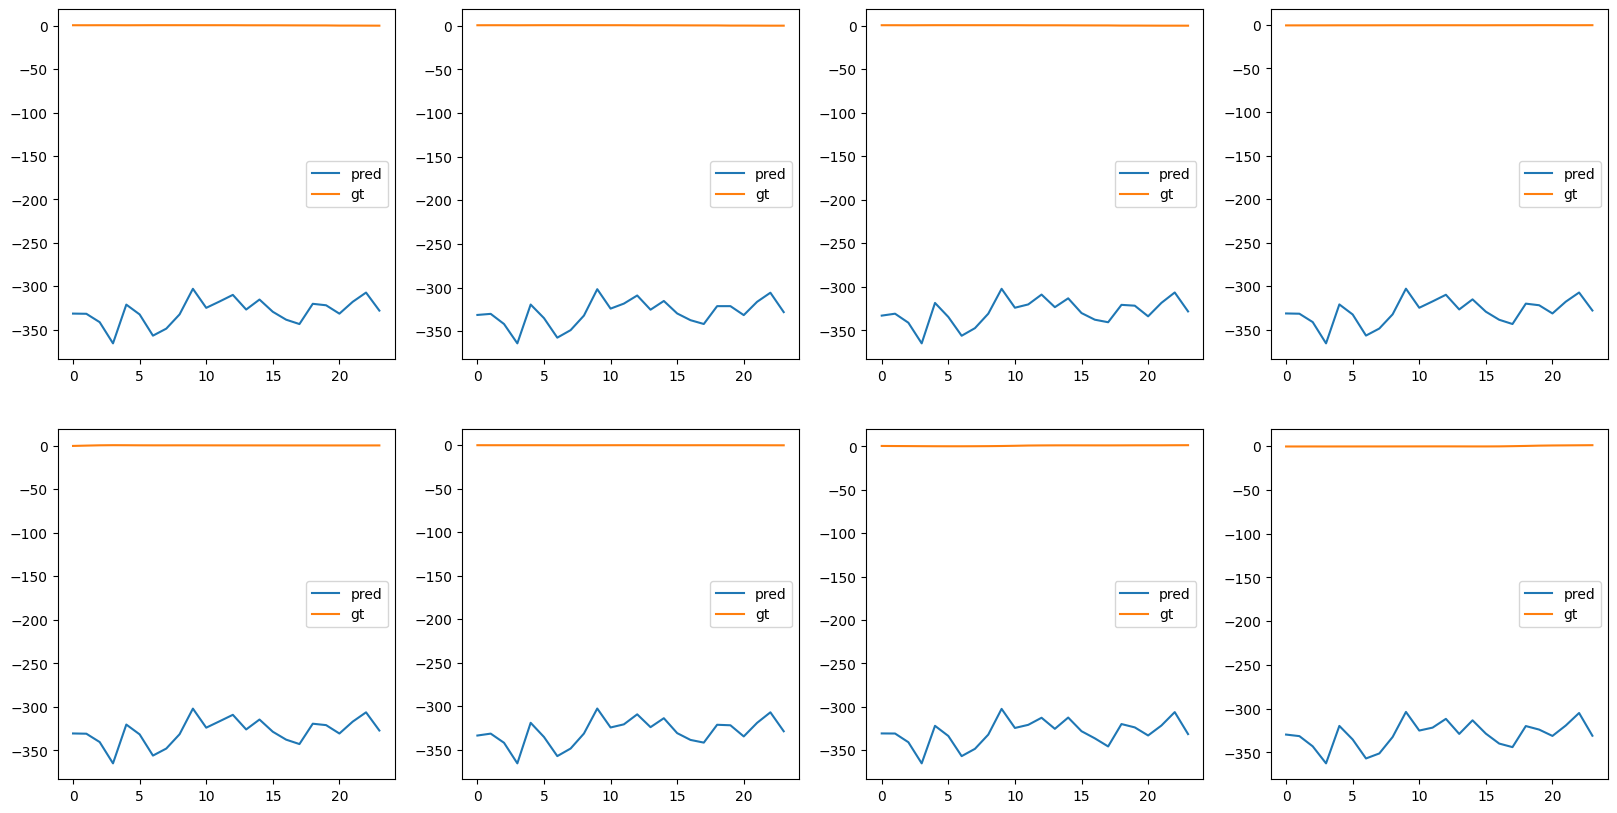

In [5]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()

## Can we do better?

In our case, there is little justification to move beyond the linear regression setting because of how the data is generated. Nevertheless, nobody is stopping us from trying. Let's now formulate our model as: $$\hat y  = (ReLU(XW^{(1)})) W^{(2)},$$
where $W^{(1)} \in R^{25 \times n_1}, W^{(2)} \in R^{n_1 \times 5}$ are learnable weight matrie and $n_1$ is a hyper-parameter we get to choose.

The main points we want to you to notice from this example are:
1. More complex models do not mean better performance;
2. Hyper-parameter tuning is tedious;
3. **Most importantly**, we can learn any differentiable architecture with the help of SGD.

In [6]:
# define model
import torch
'''
class MLP(torch.nn.Module):
    def __init__(self, n1):
        super(MLP, self).__init__()
        self.linear = torch.nn.Linear(25, n1)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(n1, 5)
        
    def forward(self, x):
        y_pred = self.linear2(self.relu(self.linear(x)))
        return y_pred'''

'\nclass MLP(torch.nn.Module):\n    def __init__(self, n1):\n        super(MLP, self).__init__()\n        self.linear = torch.nn.Linear(25, n1)\n        self.relu = torch.nn.ReLU()\n        self.linear2 = torch.nn.Linear(n1, 5)\n        \n    def forward(self, x):\n        y_pred = self.linear2(self.relu(self.linear(x)))\n        return y_pred'

In [7]:
# train model
from models import mlp

best_loss = 1e10
model = mlp.MLP(192, 6, 24, 36, 3, 0.3)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for epoch in range(10):
    for i, d in enumerate(train_loader):
        # Forward pass
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        for i, d in enumerate(val_loader):
            outputs = model(d.get('inputs'))
            loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model.pth')
# load best model
model.load_state_dict(torch.load('best_model.pth'))

Epoch [1/100], Loss: nan
Epoch [1/100], Val Loss: nan
Epoch [2/100], Loss: nan
Epoch [2/100], Val Loss: nan
Epoch [3/100], Loss: nan
Epoch [3/100], Val Loss: nan
Epoch [4/100], Loss: nan
Epoch [4/100], Val Loss: nan
Epoch [5/100], Loss: nan
Epoch [5/100], Val Loss: nan
Epoch [6/100], Loss: nan
Epoch [6/100], Val Loss: nan
Epoch [7/100], Loss: nan
Epoch [7/100], Val Loss: nan
Epoch [8/100], Loss: nan
Epoch [8/100], Val Loss: nan
Epoch [9/100], Loss: nan
Epoch [9/100], Val Loss: nan
Epoch [10/100], Loss: nan
Epoch [10/100], Val Loss: nan


<All keys matched successfully>

In [8]:
# evaluate model on test set
with torch.no_grad():
    for i, d in enumerate(test_loader):
        outputs = model(d.get('inputs'))
        labels = d.get('outputs')
        loss = criterion(outputs[1], labels)
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

/opt/homebrew/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 24, 1])) that is different to the input size (torch.Size([24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Test Loss: 528.8033


/opt/homebrew/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8, 24, 1])) that is different to the input size (torch.Size([24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


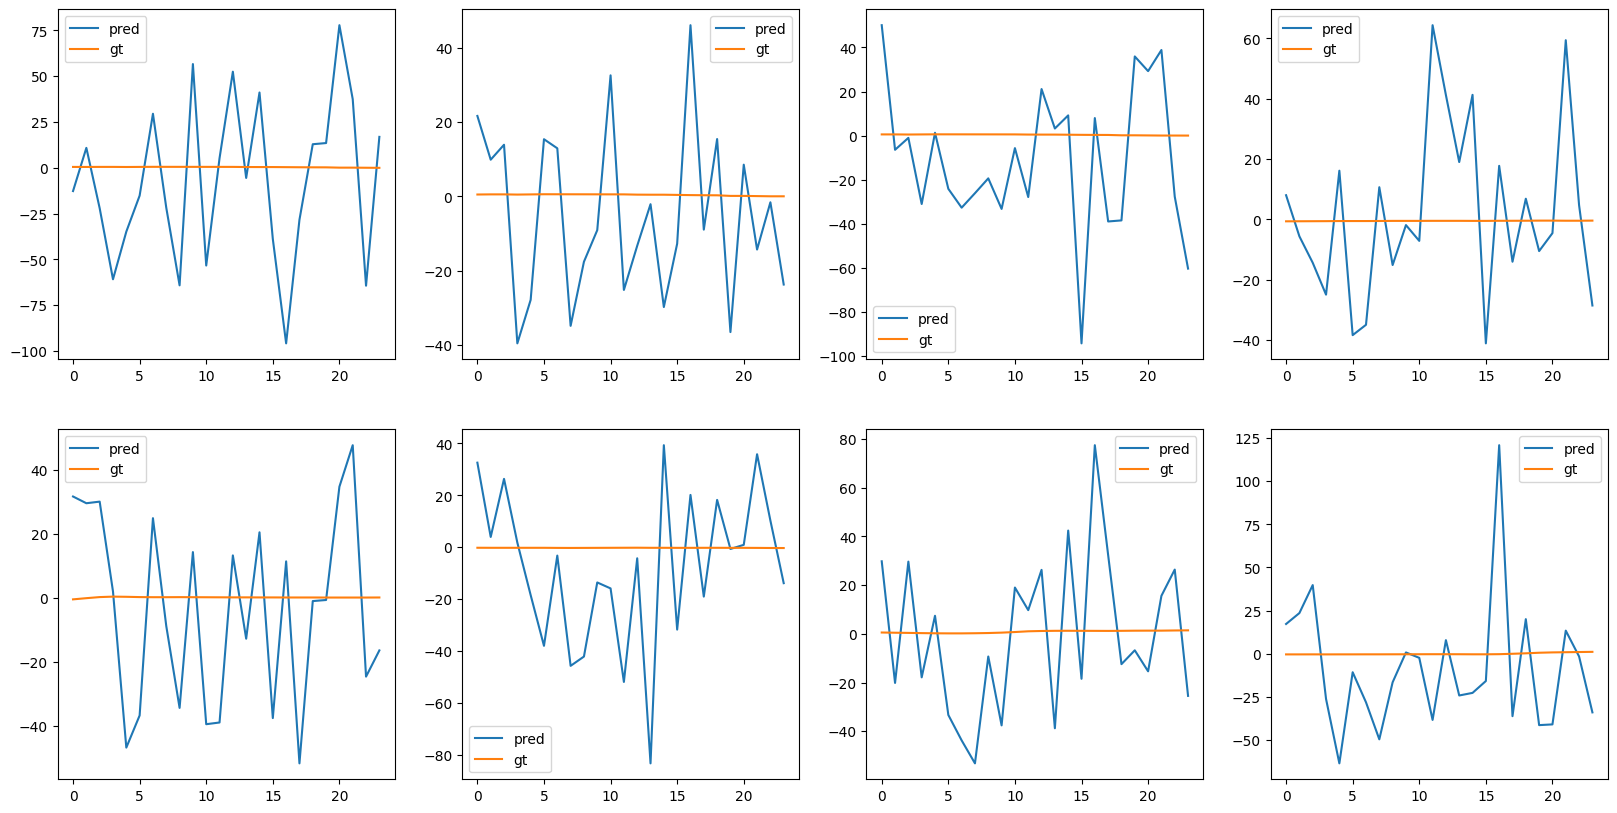

In [9]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()